In [1]:
from causalml.inference.meta import LRSRegressor

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [35]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

Failed to import duecredit due to No module named 'duecredit'


In [3]:
import importlib
print(importlib.metadata.version('causalml') )

0.14.1


In [4]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

In [5]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# After calling estimate_ate, add pretrain=True flag to skip training
# This flag is applicable for other meta learner
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, pretrain=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.67807004]), array([0.63014354]), array([0.72599654]))
ATE estimate: 0.678
ATE lower bound: 0.630
ATE upper bound: 0.726
(array([0.67807004]), array([0.63014354]), array([0.72599654]))
ATE estimate: 0.678
ATE lower bound: 0.630
ATE upper bound: 0.726


In [10]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([0.53637473]), array([0.51291097]), array([0.55983849]))

Using the BaseTRegressor class and using XGB (same result):
(array([0.53637473]), array([0.51291097]), array([0.55983849]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.66746045]), array([0.62724105]), array([0.70767985]))


In [12]:
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

Using the BaseXRegressor class and using XGB without propensity score input:
(array([0.52334408]), array([0.50366019]), array([0.54302796]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([0.66746045]), array([0.62724105]), array([0.70767985]))


In [13]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([0.52061974]), array([0.50092903]), array([0.54031044]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.66746045]), array([0.62724105]), array([0.70767985]))


# Calculate CATE

In [33]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

In [31]:
cate_t

array([[ 0.03973973],
       [-0.15422595],
       [ 0.2623502 ],
       ...,
       [ 1.26155591],
       [ 0.67344379],
       [ 0.92214429]])

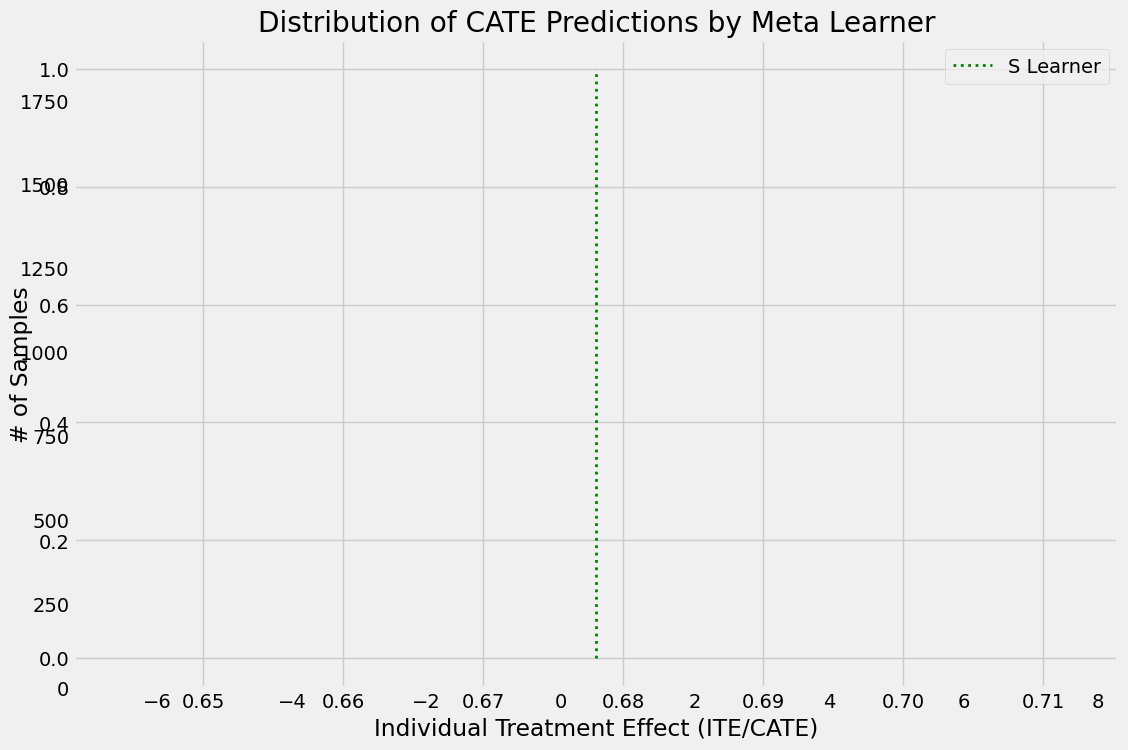

In [36]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()